# import lib

In [1]:
import os
import os.path as op
import shutil
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from PIL import Image
from torchvision import datasets, models, transforms
import torchvision.transforms as T
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# load Data
from https://www.kaggle.com/competitions/dog-breed-identification/data

In [2]:
img_df = pd.DataFrame(glob("trainall/*.jpg"), columns=["path"])
img_df["id"] = img_df.path.map(lambda x: op.basename(x).replace(".jpg", ""))

# read label data
label_df = pd.read_csv("labels.csv")
train_df = img_df.merge(label_df, on="id")

In [3]:
train_df.head()

,path,id,breed
0,trainall\000bec180eb18c7604dcecc8fe0dba07.jpg,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,trainall\001513dfcb2ffafc82cccf4d8bbaba97.jpg,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,trainall\001cdf01b096e06d78e9e5112d419397.jpg,001cdf01b096e06d78e9e5112d419397,pekinese
3,trainall\00214f311d5d2247d5dfe4fe24b2303d.jpg,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,trainall\0021f9ceb3235effd7fcde7f7538ed62.jpg,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


# split data to "train", "validation"

In [4]:
train_df, validation_df = train_test_split(train_df, test_size=0.2, random_state=3)

In [5]:
print("Length of training set = {}, validation set = {}".format(len(train_df), len(validation_df)))

Length of training set = 8177, validation set = 2045


In [6]:
root_dir = "dogdata/"
for df, f in zip([train_df, validation_df], ["train", "validation"]):
    for _, r in df.iterrows():
        # create subfolder if it doesn't exist
        d = op.join(root_dir, f, r.breed)
        if not op.exists(d):
            os.makedirs(d)
        shutil.copy(r.path, op.join(root_dir, f, r.breed, f"{r.id}.jpg"))

In [7]:
import torch
import torch.nn as nn
from tqdm.auto import tqdm
import torch.nn.functional as F
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support

In [8]:
#https://pytorch.org/vision/0.9/transforms.html
#the mean values for the three channels (red, green, blue) are 0.485, 0.456, and 0.406,
#the standard deviation values for the three channels (red, green, blue) are 0.229, 0.224, and 0.225
train_transform = T.Compose([
    T.Resize(256),
    T.RandomHorizontalFlip(p=0.5),
    T.TrivialAugmentWide(),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])
val_transform = T.Compose([
    T.Resize(256),
    T.RandomHorizontalFlip(p=0.5),
    T.TrivialAugmentWide(),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [9]:
train_data = datasets.ImageFolder("dogdata/train/", transform=train_transform)
val_data = datasets.ImageFolder("dogdata/validation/", transform=val_transform)

In [10]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

In [11]:
n_train = len(train_loader.dataset)
n_val = len(val_loader.dataset)

In [12]:
n_train,n_val

(8344, 2220)

In [13]:
images, labels = next(iter(train_loader))

In [14]:
images.shape, labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

# My Model CNN

In [173]:

class DogClassifier(nn.Module):
    def __init__(self, num_classes):
        super(DogClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 *56 *56, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Initialize the dog classification model
num_classes = len(train_data.classes)
model = DogClassifier(num_classes)

# resnet34 for pretrained 


The structure of the ResNet34 CNN Network
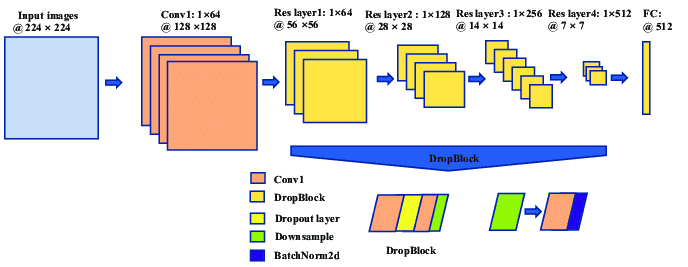


In [19]:
#resnet34 for pretrained (compare training time and loss)
model = models.resnet34(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

C:\Users\trueh\anaconda3\envs\tensor\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\trueh\anaconda3\envs\tensor\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:
model.fc = nn.Linear(in_features=512, out_features=len(train_data.classes))

In [15]:
len(train_data.classes)

120

In [16]:
train_data.classes

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle',
 'bedlington_terrier',
 'bernese_mountain_dog',
 'black-and-tan_coonhound',
 'blenheim_spaniel',
 'bloodhound',
 'bluetick',
 'border_collie',
 'border_terrier',
 'borzoi',
 'boston_bull',
 'bouvier_des_flandres',
 'boxer',
 'brabancon_griffon',
 'briard',
 'brittany_spaniel',
 'bull_mastiff',
 'cairn',
 'cardigan',
 'chesapeake_bay_retriever',
 'chihuahua',
 'chow',
 'clumber',
 'cocker_spaniel',
 'collie',
 'curly-coated_retriever',
 'dandie_dinmont',
 'dhole',
 'dingo',
 'doberman',
 'english_foxhound',
 'english_setter',
 'english_springer',
 'entlebucher',
 'eskimo_dog',
 'flat-coated_retriever',
 'french_bulldog',
 'german_shepherd',
 'german_short-haired_pointer',
 'giant_schnauzer',
 'golden_retriever',
 'gordon_setter',
 'great_dane',
 'great_pyrenees',
 'greater_swiss_mountain_dog',
 'groenendael',


In [176]:
#implements the stochastic gradient descent (SGD) optimization algorithm
cross_entropy = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=2e-3)

In [163]:
gpu = torch.cuda.is_available()
print(gpu)
if gpu:
    model.cuda()

False


# Train My CNN

In [177]:
#My CNN##
n_epochs = 4
for epoch in range(n_epochs):
    # ช่วง train
    model.train()
    train_loss, val_loss = 0, 0
    for images, labels in tqdm(train_loader):
        if gpu:
            images, labels = images.cuda(), labels.cuda()
        optimizer.zero_grad()
        pred = model(images) # คำนวณหา output (pred) จาก โมเดลที่มีอยู่
        loss = cross_entropy(pred, labels)
        loss.backward() # คำนวณ gradient จาก loss ที่ได้
        optimizer.step() # อัพเดทพารามิเตอร์ของโมเดล
        train_loss += loss.item() * images.size(0)

    # ช่วง validate
    model.eval() # เซ็ตเป็น evaluation mode
    for images, labels in tqdm(val_loader):
        if gpu:
            images, labels = images.cuda(), labels.cuda()
        pred = model(images)
        loss = cross_entropy(pred, labels)
        val_loss += loss.item() * images.size(0)
    print("Training loss = {}, Validation loss = {}".format(train_loss / n_train, val_loss / n_val))

  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Training loss = 4.7748706973982, Validation loss = 4.757071092966441


  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Training loss = 4.722576151872527, Validation loss = 4.706214158169858


  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Training loss = 4.663907338194513, Validation loss = 4.661010194898726


  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Training loss = 4.611442653239059, Validation loss = 4.618454623007559


# Evaluate My CNN

In [178]:
y_pred, y_true = [], []
model.eval() # เซ็ตเป็น evaluation mode
for images, labels in tqdm(val_loader):    
    if gpu:
        images, labels = images.cuda(), labels.cuda()
    pred = model(images)
    yp = pred.argmax(dim=1).tolist()
    yt = labels.tolist()
    y_pred.extend(yp)
    y_true.extend(yt)
print(classification_report(y_true, y_pred))

  0%|          | 0/70 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.08      0.04      0.05        24
           2       0.00      0.00      0.00        14
           3       0.02      0.04      0.03        23
           4       0.00      0.00      0.00        15
           5       0.00      0.00      0.00        19
           6       0.00      0.00      0.00        23
           7       0.00      0.00      0.00        17
           8       0.00      0.00      0.00        15
           9       0.33      0.05      0.08        21
          10       0.00      0.00      0.00        24
          11       0.02      0.20      0.04        25
          12       0.00      0.00      0.00        17
          13       0.00      0.00      0.00        28
          14       0.00      0.00      0.00        17
          15       0.00      0.00      0.00        22
          16       0.00      0.00      0.00        18
          17       0.00    

C:\Users\trueh\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\trueh\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\trueh\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Train resnet34

In [165]:
#pretrain##
n_epochs = 4
for epoch in range(n_epochs):
    # ช่วง train
    model.train()
    train_loss, val_loss = 0, 0
    for images, labels in tqdm(train_loader):
        if gpu:
            images, labels = images.cuda(), labels.cuda()
        optimizer.zero_grad()
        pred = model(images) # คำนวณหา output (pred) จาก โมเดลที่มีอยู่
        loss = cross_entropy(pred, labels)
        loss.backward() # คำนวณ gradient จาก loss ที่ได้
        optimizer.step() # อัพเดทพารามิเตอร์ของโมเดล
        train_loss += loss.item() * images.size(0)

    # ช่วง validate
    model.eval() # เซ็ตเป็น evaluation mode
    for images, labels in tqdm(val_loader):
        if gpu:
            images, labels = images.cuda(), labels.cuda()
        pred = model(images)
        loss = cross_entropy(pred, labels)
        val_loss += loss.item() * images.size(0)
    print("Training loss = {}, Validation loss = {}".format(train_loss / n_train, val_loss / n_val))

  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Training loss = 4.633497280676779, Validation loss = 4.440888708990974


  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Training loss = 4.281441409658723, Validation loss = 4.0936445313531


  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Training loss = 3.9608797279551755, Validation loss = 3.79604755865561


  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Training loss = 3.673725052510789, Validation loss = 3.5152550095910424


# Evaluate resnet34

In [166]:
y_pred, y_true = [], []
model.eval() # เซ็ตเป็น evaluation mode
for images, labels in tqdm(val_loader):    
    if gpu:
        images, labels = images.cuda(), labels.cuda()
    pred = model(images)
    yp = pred.argmax(dim=1).tolist()
    yt = labels.tolist()
    y_pred.extend(yp)
    y_true.extend(yt)
print(classification_report(y_true, y_pred))


  0%|          | 0/70 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.47      0.83      0.60        24
           2       0.27      0.50      0.35        14
           3       0.28      0.57      0.38        23
           4       0.30      0.20      0.24        15
           5       0.00      0.00      0.00        19
           6       0.29      0.22      0.25        23
           7       0.24      0.82      0.37        17
           8       0.36      0.27      0.31        15
           9       0.28      0.52      0.36        21
          10       0.67      0.50      0.57        24
          11       0.61      0.80      0.69        25
          12       0.08      0.06      0.07        17
          13       0.36      0.71      0.48        28
          14       0.50      0.35      0.41        17
          15       0.38      0.14      0.20        22
          16       1.00      0.06      0.11        18
          17       0.32    

C:\Users\trueh\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\trueh\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\trueh\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Compare MyCNN , resnet34
1 Model size => accuracy
2 Model size => Training Time
resnet34 Validation loss = 3.5 ,  accuracy f1-score 0.35
MyCNN    Validation loss = 4.61 ,  accuracy f1-score 0.03
Choose Pretrained Model

# show image with cv2

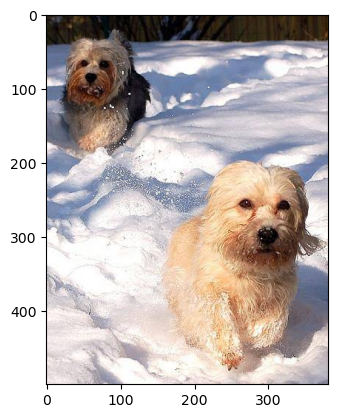

In [95]:
import cv2
import matplotlib.pylab as plt
image_path='test/ffbb6663b38e903dbd1efa5dce2d0bbb.jpg'
image = cv2.imread(image_path)
image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [100]:
torch.manual_seed(123)

# predict image

In [121]:
image = Image.open(image_path)
image_tranform=train_transform(image)
image_tranform.shape
input_batch = image_tranform.unsqueeze(0)
pred = model(input_batch)
pred.shape

torch.Size([1, 120])

In [122]:
pred

tensor([[ 7.7887e-01,  8.3625e-01,  1.8772e-01,  6.2514e-01, -9.6731e-01,
         -4.2931e-01,  8.4687e-01, -1.0968e+00, -2.5555e-01,  1.3273e-01,
         -7.4416e-02,  4.0146e-02, -3.8406e-01, -1.0655e+00,  5.1896e-01,
          2.4632e-01, -1.6942e-01,  1.8829e+00, -4.7954e-01, -1.5408e-01,
         -2.3112e-01, -1.5098e-01, -4.3329e-01, -5.7711e-01, -1.3040e+00,
          2.5839e-01,  1.2075e+00,  3.3539e-01,  7.9094e-01, -2.3667e-01,
          4.6967e-01,  3.2705e-01,  2.7291e-04, -1.4556e-01, -2.4489e-01,
          1.2695e+00,  3.5071e-01,  6.7785e-01, -9.9969e-01, -4.5430e-02,
         -4.7353e-03, -8.6416e-01, -1.1114e+00, -7.1220e-01, -4.7432e-01,
         -9.6117e-01,  1.3355e-01,  7.5536e-02, -7.2011e-01,  7.5640e-01,
          6.1088e-01, -2.9121e-01,  5.0050e-01, -1.6670e-01, -2.3638e-01,
         -1.5208e-01,  6.5320e-01,  4.4025e-01,  2.4256e-01,  1.1706e+00,
         -4.6816e-01,  6.2204e-01, -2.8844e-01,  4.5712e-01, -1.0825e+00,
          4.5232e-01, -1.2962e-01, -3.

In [123]:
predicted_class_index = torch.argmax(pred, dim=1)
predicted_class_index

tensor([17])

In [124]:
# Get the predicted label from the class_labels list
predicted_label = train_data.classes[predicted_class_index.item()]

# Now, you can print the predicted label
print(predicted_label)

border_terrier


# save the model

In [179]:
model_path = 'dog_classification-model.pth'
#model_path = 'dog_classification-model-pretrain.pth'
torch.save(model, model_path)


# load the model

In [75]:
model_path = 'dog_classification-model-pretrain.pth'
model = torch.load(model_path)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [180]:
model_path = 'dog_classification-model.pth'
model = torch.load(model_path)
model.eval()

DogClassifier(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=200704, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=120, bias=True)
  )
  (fc): Linear(in_features=512, out_features=120, bias=True)
)

The benefits of using BatchNorm2d include faster convergence, better generalization, and reduced sensitivity to the initial values of the model's parameters. 

Curves of the Sigmoid, Tanh, and ReLu activation functions. 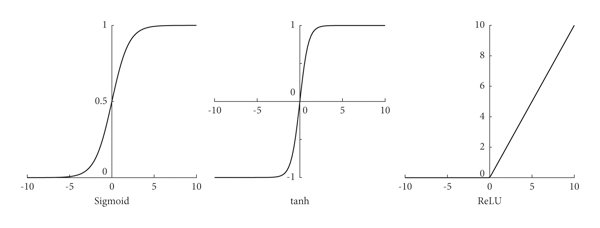